ECEN 5001-001: Neuromorphic and Unconventional Computing        
Mid-term Project - Mohit Bhatt, Satya Mohit Rao Kamkanampati

# Multi-Basis Quantum Reservoir Computing with Variational Readout

In this project we develop an innovative hybrid quantum–classical model with two major breakthroughs:

1. **Multi-Basis Quantum Reservoir:**  
   The quantum reservoir circuit is measured in multiple bases (Z, X, and Y). This enriches the feature set by capturing different aspects of the quantum state.

2. **Nonlinear Classical Readout:**  
   Instead of a simple linear regression, we use a neural network (MLPRegressor) to map the high-dimensional quantum features to the target output. This variational readout is tuned to improve prediction accuracy.

We will apply this model to a synthetic time series prediction task (predicting the next value of a sine wave), evaluate performance using MSE and \( R^2 \), and compute a custom “accuracy” based on error metrics.


In [1]:
!pip install --upgrade qiskit scikit-learn
!pip install qiskit_aer

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Qiskit imports using the latest APIs
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# Classical machine learning libraries
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [3]:
np.random.seed(42)

In [4]:
def quantum_reservoir_circuit(input_value, num_qubits=4, layers=2, meas_basis="Z"):
    """
    Constructs a quantum reservoir circuit for a given classical input and measurement basis.

    Parameters:
      input_value (float): The classical input value to encode.
      num_qubits (int): Number of qubits in the reservoir.
      layers (int): Number of reservoir layers.
      meas_basis (str): Which measurement basis to use ("Z", "X", or "Y").

    Returns:
      QuantumCircuit: The quantum circuit including measurement rotations.
    """
    qc = QuantumCircuit(num_qubits, num_qubits)

    # Input Encoding: RY rotations (with a small random offset)
    for q in range(num_qubits):
        qc.ry(input_value + np.random.rand(), q)

    # Reservoir Layers: Each layer with CCX (toffoli) (entanglement) and RY rotations
    for _ in range(layers):
        for q in range(num_qubits - 2):
            qc.ccx(q, q + 1, q + 2)
        for q in range(num_qubits):
            theta = np.random.rand() * np.pi
            qc.ry(theta, q)
        qc.barrier()

    # Basis Rotation for Measurement:
    if meas_basis.upper() == "X":
        # To measure in X basis, apply Hadamard
        for q in range(num_qubits):
            qc.h(q)
    elif meas_basis.upper() == "Y":
        # To measure in Y basis, apply S† (Sdg) then Hadamard
        for q in range(num_qubits):
            qc.sdg(q)
            qc.h(q)
    # For "Z" basis, no rotation is needed

    # Measurement: measure all qubits
    qc.measure(range(num_qubits), range(num_qubits))
    qc.draw('mpl')
    plt.show()
    return qc


In [5]:
def run_quantum_reservoir_features(input_value, num_qubits=4, layers=2, shots=4096, meas_basis="Z"):
    """
    Executes the quantum reservoir circuit and returns a normalized feature vector.

    Parameters:
      input_value (float): The classical input value.
      num_qubits (int): Number of qubits.
      layers (int): Number of reservoir layers.
      shots (int): Number of simulation shots.
      meas_basis (str): Measurement basis ("Z", "X", or "Y").

    Returns:
      np.array: Normalized feature vector of length 2^(num_qubits).
    """
    qc = quantum_reservoir_circuit(input_value, num_qubits=num_qubits, layers=layers, meas_basis=meas_basis)
    simulator = AerSimulator()
    transpiled_qc = transpile(qc, simulator)
    result = simulator.run(transpiled_qc, shots=shots).result()
    counts = result.get_counts(0)

    # Create feature vector
    vec = np.zeros(2**num_qubits)
    for outcome, count in counts.items():
        idx = int(outcome, 2)
        vec[idx] = count
    return vec / shots  # Normalize to probabilities


In [6]:
def extract_multibasis_features(x_value, num_qubits=4, layers=2, shots=4096):
    bases = ["Z", "X", "Y"]
    features = []
    for basis in bases:
        feat = run_quantum_reservoir_features(x_value, num_qubits=num_qubits, layers=layers, shots=shots, meas_basis=basis)
        features.append(feat)
    # Concatenate features from different bases into one vector
    return np.concatenate(features)

# Test the multi-basis feature extraction on one sample
sample_features = extract_multibasis_features(0.5)
print("Feature vector length (should be 3*2^num_qubits):", len(sample_features))


Feature vector length (should be 3*2^num_qubits): 48


In [7]:
# Generate a sine wave time series
t = np.linspace(0, 4*np.pi, 100)
data = np.sin(t)

# Create dataset: input is current value, target is next value
X_data = data[:-1]
y_data = data[1:]


In [8]:
num_qubits = 4
layers = 2
shots = 4096

features = [extract_multibasis_features(x, num_qubits, layers, shots) for x in X_data]
features = np.array(features)
print("Feature matrix shape:", features.shape)


Feature matrix shape: (99, 48)


In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, y_data, test_size=0.2, random_state=42)

# Baseline: Ridge Regression with scaling
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

ridge_model = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print("Baseline Ridge Regression:")
print("Test MSE:", mse_ridge)
print("Test R^2:", r2_ridge)


Baseline Ridge Regression:
Test MSE: 0.7654477492929341
Test R^2: -0.6764181203362649


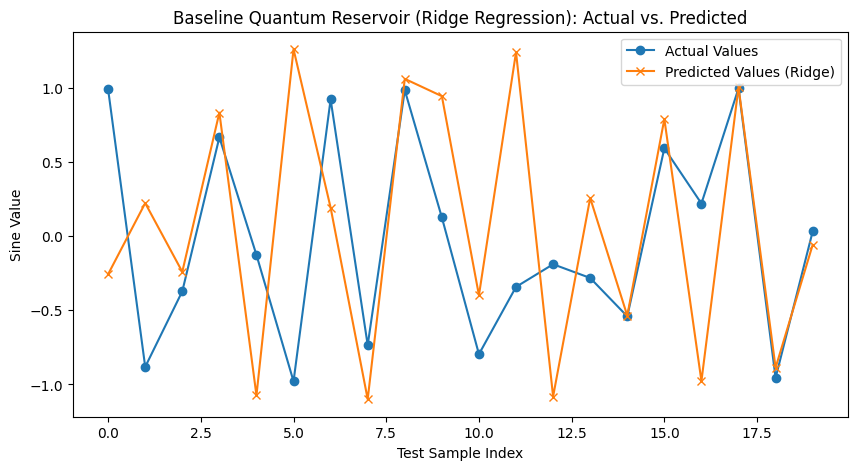

Baseline Ridge Regression:
Test MSE: 0.7654477492929341
Test R^2: -0.6764181203362649
Model 'accuracy' based on R^2: -67.64%


In [10]:
# Plot predictions from the baseline Ridge model (before improvements)
plt.figure(figsize=(10,5))
plt.plot(y_test, 'o-', label='Actual Values')
plt.plot(y_pred_ridge, 'x-', label='Predicted Values (Ridge)')
plt.xlabel('Test Sample Index')
plt.ylabel('Sine Value')
plt.title('Baseline Quantum Reservoir (Ridge Regression): Actual vs. Predicted')
plt.legend()
plt.show()

# Print baseline performance metrics
print("Baseline Ridge Regression:")
print("Test MSE:", mse_ridge)
print("Test R^2:", r2_ridge)
accuracy_from_ridge = r2_ridge * 100
print(f"Model 'accuracy' based on R^2: {accuracy_from_ridge:.2f}%")


Innovative Improvement: Use a Nonlinear Neural Network as Readout (Code)

Now we replace Ridge regression with a neural network (MLPRegressor) for the classical readout to improve accuracy.

In [11]:
# Improved readout: MLPRegressor
mlp_model = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(50,50), max_iter=1000, random_state=42))
mlp_model.fit(X_train, y_train)

y_pred_mlp = mlp_model.predict(X_test)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)
print("Improved MLP Regressor:")
print("Test MSE:", mse_mlp)
print("Test R^2:", r2_mlp)


Improved MLP Regressor:
Test MSE: 0.5882651412433934
Test R^2: -0.28836794314642367


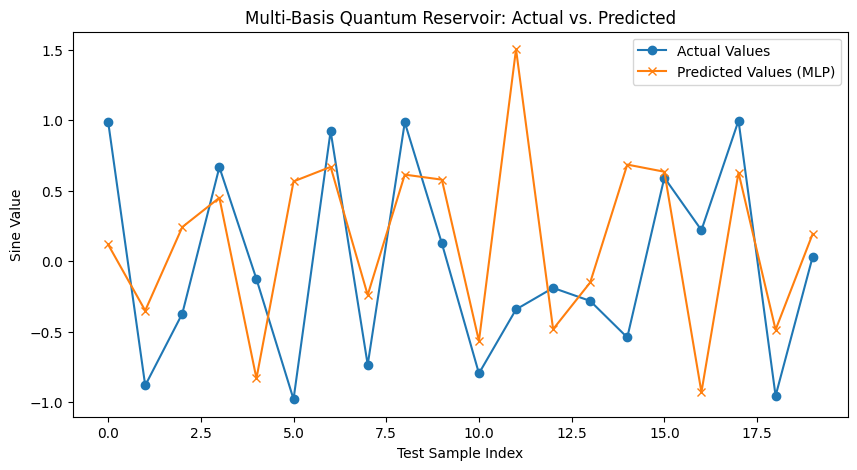

Model 'accuracy' based on R^2: -28.84%


In [12]:
plt.figure(figsize=(10,5))
plt.plot(y_test, 'o-', label='Actual Values')
plt.plot(y_pred_mlp, 'x-', label='Predicted Values (MLP)')
plt.xlabel('Test Sample Index')
plt.ylabel('Sine Value')
plt.title('Multi-Basis Quantum Reservoir: Actual vs. Predicted')
plt.legend()
plt.show()
accuracy_from_r2 = r2_mlp * 100
print(f"Model 'accuracy' based on R^2: {accuracy_from_r2:.2f}%")
